# Assignment 3: Exploring Tree-Based Regression Methods for 3D Sinusoidal Data
## DTSC 680: Applied Machine Learning

## Name: Brian Beadell

## Directions and Overview

The main purpose of this assignment is for you to gain experience using tree-based methods to solve simple regression problems.  In this assignment, you will fit a `Gradient-Boosted Regression Tree`, a `Random Forest`, and a `Decision Tree` to a noisy 3D sinusoidal data set.  Since these models can be trained very quickly on the supplied data, I want you to first manually adjust hyperparameter values and observe their influence on the model's predictions.  That is, you should manually sweep the hyperparameter space and try to hone in on the optimal hyperparameter values, again, _manually_.  (Yep, that means guess-and-check: pick some values, train the model, observe the prediction curve, repeat.)

But wait, there's more! Merely attempting to identify the optimal hyperparameter values is not enough.  Be sure to really get a visceral understanding of how altering a hyperparameter in turn alters the model predictions (i.e. the prediction curve).  This is how you will build your machine learning intuition!

So, play around and build some models.  When you are done playing with hyperparameter values, you should try to set these values to the optimal values manually (you're likely going to be _way_ off).  Then, retrain the model.  Next in this assignment, we will perform several grid searches, so you'll be able to compare your "optimal" hyperparameter values with those computed from the grid search.

We will visualize model predictions for the optimal `Gradient-Boosted Regression Tree`, a `Random Forest`, and `Decision Tree` models that were determined by the grid searches.  Next, you will compute the generalization error on the test set for the three models.

## Preliminaries

Let's import some common packages:

In [1]:
# Common imports
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import numpy as np
import pandas as pd
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import os
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Where to save the figures
PROJECT_ROOT_DIR = "."
FOLDER = "figures"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, FOLDER)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
def plot3Ddata(data_df):
    fig = plt.figure(figsize=(14, 10))
    angles = [(0, 90), (30, -360), (60, -60), (30, -330)]
    for i in range(4):
        ax = fig.add_subplot(2, 2, i + 1, projection='3d')
        scatter = ax.scatter(data_df['x'], data_df['y'], data_df['z'],
                             c='blue', s=40, edgecolor='k')
        ax.view_init(elev=angles[i][0], azim=angles[i][1])
        ax.set_xlabel('x', fontsize=14, color='red')
        ax.set_ylabel('y', fontsize=14, color='red'), ax.set_ylim([-6, 6])
        ax.set_zlabel('z', fontsize=14, color='red')
        
    plt.tight_layout()
    plt.show()

def plotscatter3Ddata(sorted_fit_x, sorted_fit_y, sorted_fit_z, scat_x, scat_y, scat_z):
    fig = plt.figure(figsize=(14, 10))
    angles = [(0, 90), (30, -360), (60, -60), (30, -330)]
    
    for i in range(4):
        ax = fig.add_subplot(2, 2, i + 1, projection='3d')
        ax.plot(sorted_fit_x, sorted_fit_y, sorted_fit_z,color='black')
        ax.scatter(scat_x, scat_y, scat_z, color='blue')
        ax.view_init(elev=angles[i][0], azim=angles[i][1])
        ax.set_xlabel('x')
        ax.set_ylabel('y'), ax.set_ylim([-6, 6])
        ax.set_zlabel('z')
        
    plt.tight_layout()
    plt.show()

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/p3/pjsy_ms5725ccqsy3bj6jc1m0000gn/T/ipykernel_75940/4160750366.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Import and Split Data

Complete the following:



1. Begin by importing the data from the file called `3DSinusoidal.csv`.  Name the returned DataFrame `data`. 

2. Call [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with a `test_size` of 20%.  `x` and `y` will be your feature data and `z` will be your response data. Save the output into `X_train`, `X_test`, `z_train`, and `z_test`, respectively.  Specify the `random_state` parameter to be `42` (do this throughout the entire note book).

In [9]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('3DSinusoidal.csv')

X = data[['x', 'y']]
z = data['z']

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=.2, random_state=42)

# Plot Data

Simply plot your training data here, so that you know what you are working with.  You must define a function called `plot3Ddata`, which accepts a Pandas DataFrame (composed of 3 spatial coordinates) and uses `scatter3D()` to plot the data.  Use this function to plot only the training data (recall that you don't even want to look at the test set, until you are ready to calculate the generalization error).  You must place the definition of this function in the existing code cell of the above __Preliminaries__ section, and have nothing other than the function invocation in the below cell. 

You must emulate the graphs shown in the respective sections below. Each of the graphs will have four subplots. Note the various viewing angles that each subplot presents - you can achieve this with the view_init() method. Be sure to label your axes as shown.

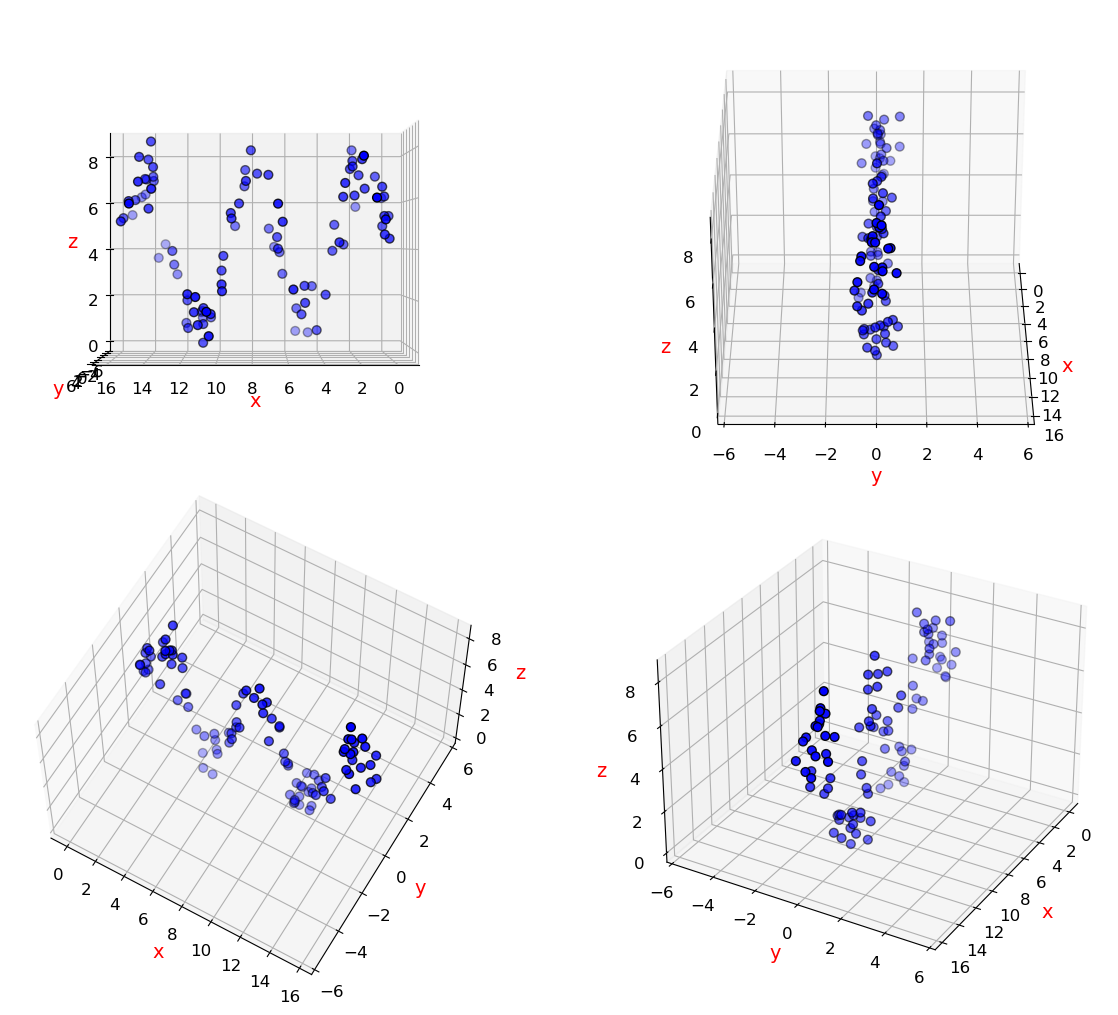

In [3]:
train_df = pd.concat([X_train, z_train], axis=1)
plot3Ddata(train_df)

## A Quick Note

In the following sections you will be asked to plot the training data along with the model's predictions for that data superimposed on it.  You must write a function called `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` that will plot this figure.  The function accepts six parameters as input, shown in the function signature.  All six input parameters must be NumPy arrays. The Numpy arrays called fit_x and fit_y represent the x and y coordinates from the training data and fit_z represents the model predictions from those coordinates (i.e. the prediction curve). The three Numpy arrays called `scat_x, scat_y,` and  `scat_z` represent the x, y, and z coordinates of the training data.   

You must place the definition of the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function in the existing code cell of the above __Preliminaries__ section. (The function header is already there - you must complete the function definition.)

You will use the `plotscatter3Ddata()` function in each of the below __Plot Model Predictions for Training Set__ portion of the three __Explore 3D Data__ sections, as well as the __Visualize Optimal Model Predictions__ section.

___Important: Below, you will be asked to plot the model's prediction curve along with the training data.  Even if you correctly train the model, you may find that your trendline is very ugly when you first plot it.  If this happens to you, try plotting the model's predictions using a scatter plot rather than a connected line plot.  You should be able to infer the problem and solution with the trendline from examining this new scatter plot of the model's predictions. All of your plots, however, should be connected line plots when submitted. Please refer to the FAQ document for more clarity.___

Note: You must use the supplied data and not np.linspace() to create the prediction curve.

# Explore 3D Data: GradientBoostingRegressor

Fit a `GradientBoostingRegressor` model to this data.  You must manually assign values to the following hyperparameters.  You should "play around" by using different combinations of hyperparameter values to really get a feel for how they affect the model's predictions.  Update the below bullets accordingly.  When you are done playing, set these to the best values you can for submission.  Update the below bullets accordingly.  (It is totally fine if you don't elucidate the optimal values here; however, you will want to make sure your model is not excessively overfitting or underfitting the data.  Do this by examining the prediction curve generated by your model.  You will be graded, more exactly, on the values that you calculate later from performing several rounds of grid searches.)

Values "played around with":
 - `learning_rate = <values>`
 - `max_depth = <values>`
 - `n_estimators = <values>`
 - `random_state = 42`

Initial "best values":
 - `learning_rate = <value>`
 - `max_depth = <value>`
 - `n_estimators = <value>`
 - `random_state = 42`

### Plot Model Predictions for Training Set

Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

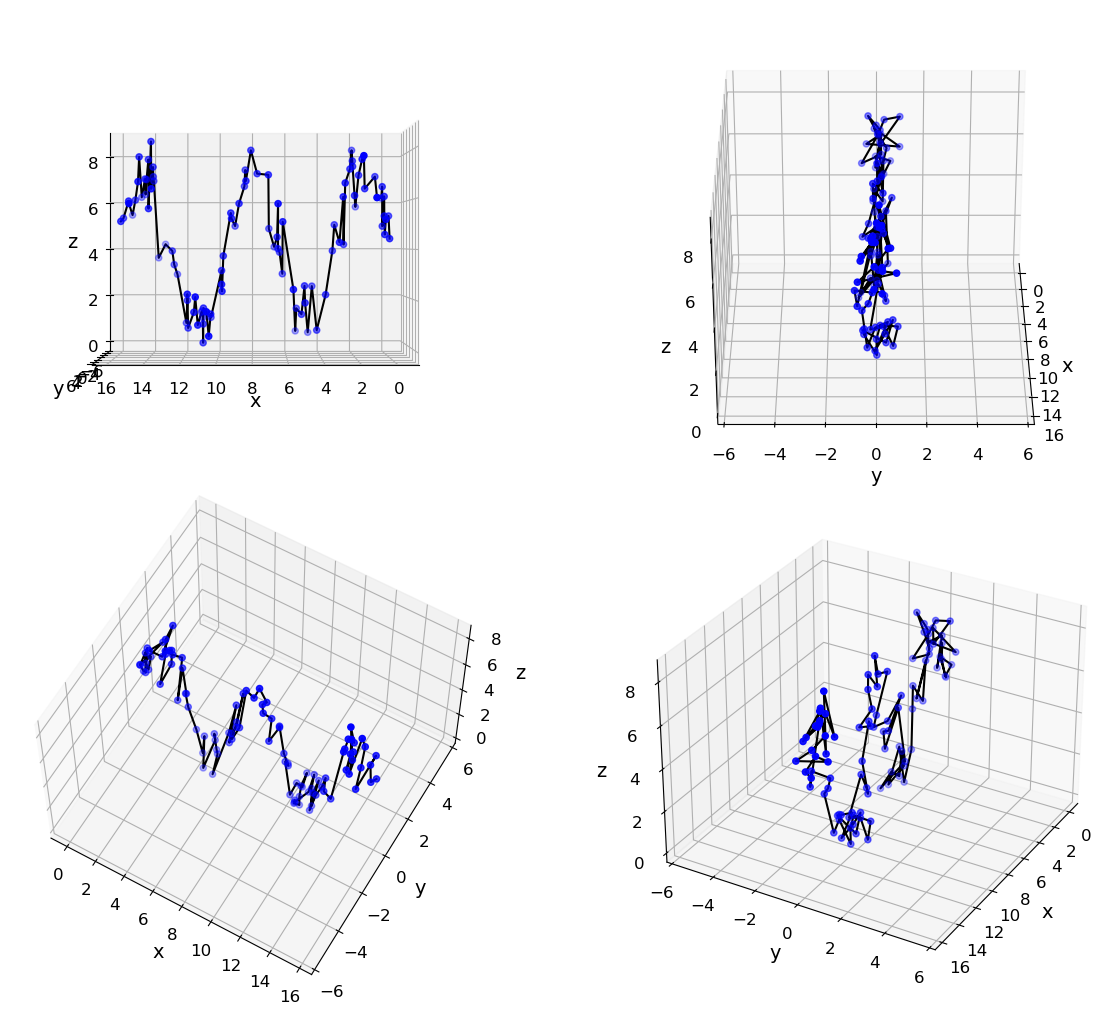

In [5]:
# Predicting using trained model
fit_x = X_train['x']
fit_y = X_train['y']
fit_z = gbrt.predict(X_train)

# Preparing for sorting
gbrt_predict = pd.DataFrame({
    'fit_x': fit_x,
    'fit_y': fit_y,
    'fit_z': fit_z
})

# Sorting by fit_x then fit_y
gbrt_predict.sort_values(by=['fit_x', 'fit_y'], inplace=True)

# Extracting sorted values
gbrt_x_sorted = gbrt_predict['fit_x'].values
gbrt_y_sorted = gbrt_predict['fit_y'].values
gbrt_z_sorted = gbrt_predict['fit_z'].values

plotscatter3Ddata(gbrt_x_sorted, gbrt_y_sorted, gbrt_z_sorted, fit_x, fit_y, z_train)

# Explore 3D Data: RandomForestRegressor

Fit a `RandomForestRegressor` model to this data.  You must manually assign values to the following hyperparameters.  You should "play around" by using different combinations of hyperparameter values to really get a feel for how they affect the model's predictions.  Update the below bullets accordingly.  When you are done playing, set these to the best values you can for submission.  Update the below bullets accordingly.  (It is totally fine if you don't elucidate the optimal values here; however, you will want to make sure your model is not excessively overfitting or underfitting the data.  Do this by examining the prediction curve generated by your model.  You will be graded, more exactly, on the values that you calculate later from performing several rounds of grid searches.)

Values "played around with":
 - `min_samples_split = <values>`
 - `max_depth = <values>`
 - `n_estimators = <values>`
 - `random_state = 42`

Initial "best values":
 - `min_samples_split = <value>`
 - `max_depth = <value>`
 - `n_estimators = <value>`
 - `random_state = 42`

In [6]:
'''
Values "played around with":

min_samples_split = 2, 4, 6, 8, 10, 11, 12, 13, 14, 15
max_depth = 5, 10, 15
n_estimators = 200, 500, 1000, 1200, 1500, 1700, 2000

Initial "best values":

min_samples_split = 10
max_depth = 10
n_estimators = 1200
'''
min_samples_split = 10
max_depth = 10
n_estimators = 1200

rf = RandomForestRegressor(min_samples_split=min_samples_split, 
                           max_depth=max_depth, 
                           n_estimators=n_estimators,
                           random_state=42)

rf.fit(X_train, z_train)

RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=1200,
                      random_state=42)

### Plot Model Predictions for Training Set

Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

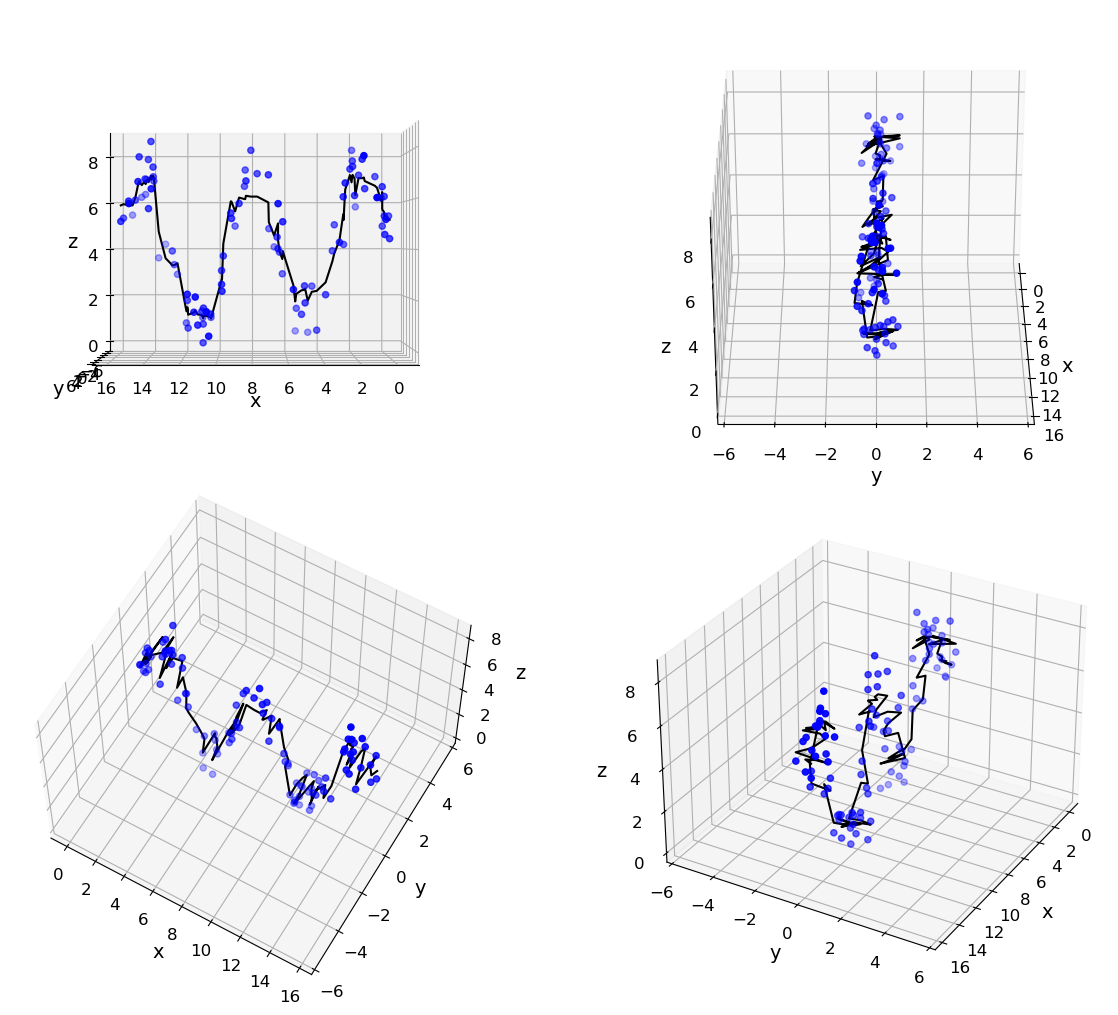

In [7]:
# Predicting using trained model
fit_x = X_train['x']
fit_y = X_train['y']
fit_z = rf.predict(X_train)

# Preparing for sorting
rf_predict = pd.DataFrame({
    'fit_x': fit_x,
    'fit_y': fit_y,
    'fit_z': fit_z
})

# Sorting by fit_x then fit_y
rf_predict.sort_values(by=['fit_x', 'fit_y'], inplace=True)

# Extracting sorted values
rf_x_sorted = rf_predict['fit_x'].values
rf_y_sorted = rf_predict['fit_y'].values
rf_z_sorted = rf_predict['fit_z'].values

plotscatter3Ddata(rf_x_sorted, rf_y_sorted, rf_z_sorted, fit_x, fit_y, z_train)

# Explore 3D Data: DecisionTreeRegressor

Fit a `DecisionTreeRegressor` model to this data.  You must manually assign values to the following hyperparameters.  You should "play around" by using different combinations of hyperparameter values to really get a feel for how they affect the model's predictions.  Update the below bullets accordingly.  When you are done playing, set these to the best values you can for submission.  Update the below bullets accordingly.  (It is totally fine if you don't elucidate the optimal values here; however, you will want to make sure your model is not excessively overfitting or underfitting the data.  Do this by examining the prediction curve generated by your model.  You will be graded, more exactly, on the values that you calculate later from performing several rounds of grid searches.)

Values "played around with":
 - `splitter = <values>`
 - `max_depth = <values>`
 - `min_samples_split = <values>`
 - `random_state = 42`

Initial "best values":
 - `splitter = <value>`
 - `max_depth = <value>`
 - `min_samples_split = <value>`
 - `random_state = 42`

In [8]:
'''
Values "played around with":

splitter = best, random
max_depth = 2, 6, 7, 8, 9, 10, 16, 20, 32
min_samples_split = 2, 4, 6, 8, 10, 12, 14 16, 22, 32
random_state = 42

Initial "best values":

splitter = 'best'
max_depth = 7
min_samples_split = 10
random_state = 42
'''

splitter = 'best'
max_depth = 7
min_samples_split = 10
random_state = 42

tree_reg = DecisionTreeRegressor(splitter=splitter, max_depth=max_depth,
                                 min_samples_split=min_samples_split, random_state=42)
                                 
tree_reg.fit(X_train, z_train)

DecisionTreeRegressor(max_depth=7, min_samples_split=10, random_state=42)

### Plot Model Predictions for Training Set

Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

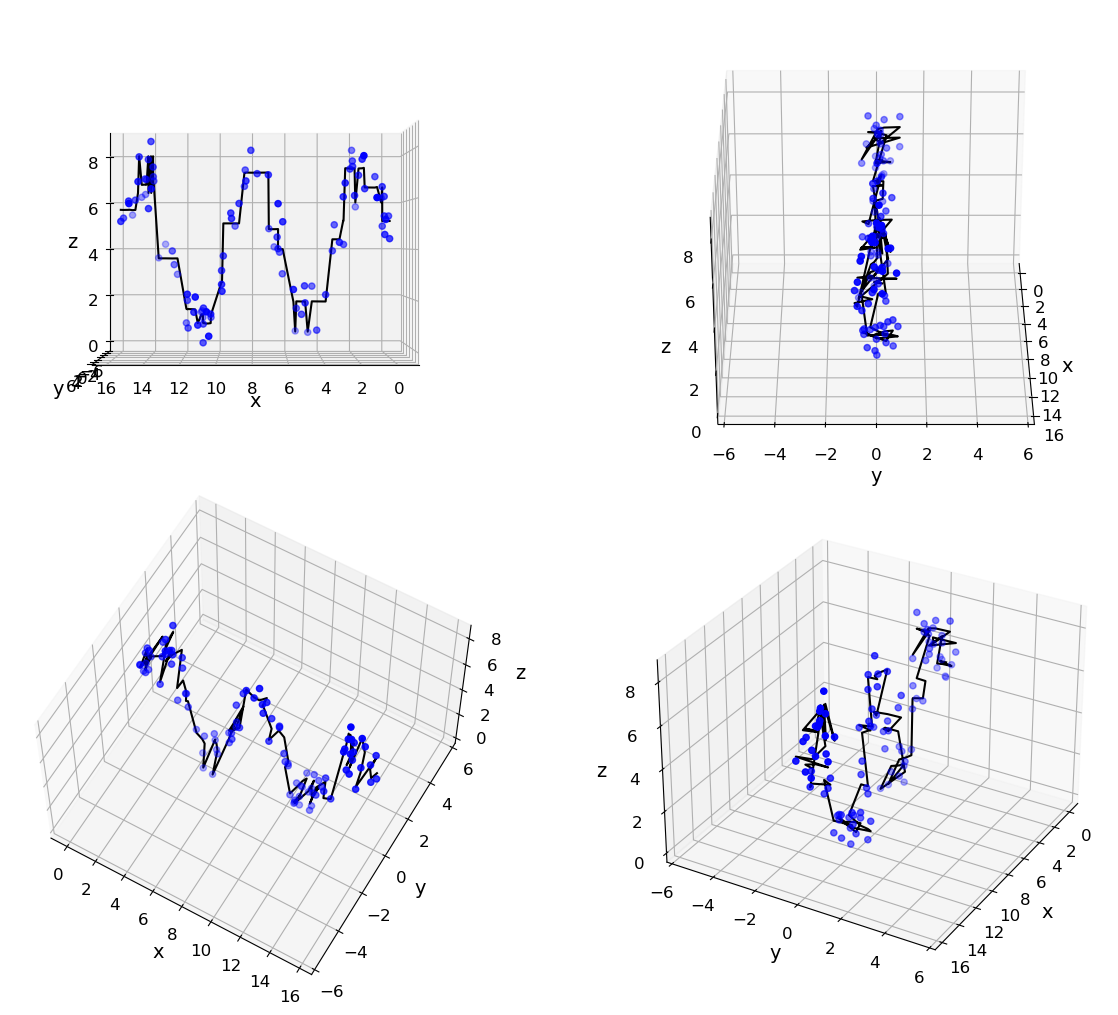

In [9]:
# Predicting using trained model
fit_x = X_train['x']
fit_y = X_train['y']
fit_z = tree_reg.predict(X_train)

# Preparing for sorting
tree_reg_predict = pd.DataFrame({
    'fit_x': fit_x,
    'fit_y': fit_y,
    'fit_z': fit_z
})

# Sorting by fit_x then fit_y
tree_reg_predict.sort_values(by=['fit_x', 'fit_y'], inplace=True)

# Extracting sorted values
tree_reg_x_sorted = tree_reg_predict['fit_x'].values
tree_reg_y_sorted = tree_reg_predict['fit_y'].values
tree_reg_z_sorted = tree_reg_predict['fit_z'].values

plotscatter3Ddata(tree_reg_x_sorted, tree_reg_y_sorted, tree_reg_z_sorted, fit_x, fit_y, z_train)

# Perform Grid Searches

You will perform a series of grid searches, which will yield the optimal hyperparamter values for each of the three model types.  You can compare the values computed by the grid search with the values you manually found earlier.  How do these compare?

You must perform a course-grained grid search, with a very broad range of values first.  Then, you perform a second grid search using a tighter range of values centered on those identified in the first grid search.  You may have to use another round of grid searching too (it took me at least three rounds of grid searches per model to ascertain the optimal hyperparameter values below).

Note the following:

1. Be sure to clearly report the optimal hyperparameters in the designated location after you calculate them!

2. You must use `random_state=42` everywhere that it is needed in this notebook.

3. You must use grid search to compute the following hyperparameters:

   GradientBoostingRegressor:
    
     - `max_depth = <value>`
     - `n_estimators = <value>`
     - `learning_rate = <value>`

   RandomForestRegressor:
    
     - `max_depth = <value>`
     - `n_estimators = <value>`
     - `min_samples_split = <value>`

   DecisionTreeRegressor:
    
     - `splitter = <value>`
     - `max_depth = <value>`
     - `min_samples_split = <value>`
     
     
4. `learning rate` should be rounded to two decimals.
5. The number of cross-folds. Specify `cv=3`


## Perform Individual Model Grid Searches

In this section you will perform a series of grid searches to compute the optimal hyperparameter values for each of the three model types.

In [10]:
# -----
# Coarse-Grained GradientBoostingRegressor GridSearch
# -----
param_grid_gbrt1 = {
    'max_depth': (1, 33),
    'n_estimators': (1, 1000),
    'learning_rate': (.01, 1)
}

gbrt = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gbrt1, cv=3, verbose=1
)

gbrt.fit(X_train, z_train)

gbrt_best_params = gbrt.best_params_
print(gbrt_best_params)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
{'learning_rate': 1, 'max_depth': 1, 'n_estimators': 1000}


In [11]:
# -----
# Refined GradientBoostingRegressor GridSearch
# -----
param_grid_gbrt2 = {
    'max_depth': [1, 2, 3, 4],
    'n_estimators': [500, 900, 1000],
    'learning_rate': [0.5, 1, 1.0, 1.5]
}

gbrt2 = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gbrt2, cv=3, verbose=1
)

gbrt2.fit(X_train, z_train)

print('The best params are: ', gbrt2.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
The best params are:  {'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 500}


In [12]:
# -----
# Final GradientBoostingRegressor GridSearch
# -----
param_grid_gbrt3 = {
    'max_depth': [3, 4, 5],
    'n_estimators': [850, 900, 950],
    'learning_rate': [0.2, 0.4, 0.5, 0.6]
}

gbrt3 = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gbrt2, cv=3, verbose=1
)

gbrt3.fit(X_train, z_train)

print('The best params are: ', gbrt3.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
The best params are:  {'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 500}


On this dataset, the optimal model parameters for the `GradientBoostingRegressor` class are:

- `learning_rate = <value>`
- `max_depth = <value>`
- `n_estimators = <value>`

In [13]:
# -----
# Coarse-Grained RandomForestRegressor GridSearch
# -----
param_grid_rf1 = {
    'min_samples_split': [2, 8, 10, 14, 32],
    'max_depth': [10, 20, 32],
    'n_estimators': [250, 500, 750, 1000]
}

rf1_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_rf1, cv=3, verbose=1
)

rf1_grid.fit(X_train, z_train)

print('The best params are: ', rf1_grid.best_params_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
The best params are:  {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 250}


In [14]:
# -----
# Refined RandomForestRegressor GridSearch
# -----
param_grid_rf2 = {
    'min_samples_split': [2, 4, 6],
    'max_depth': [6, 8, 10, 12, 14],
    'n_estimators': [200, 250, 300]
}

rf2_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_rf2, cv=3, verbose=1
)

rf2_grid.fit(X_train, z_train)

print('The best params are: ', rf2_grid.best_params_)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
The best params are:  {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 250}


In [15]:
# -----
# Final RandomForestRegressor GridSearch
# -----
param_grid_rf3 = {
    'min_samples_split': [2],
    'max_depth': [9, 10, 11],
    'n_estimators': [240, 245, 250, 255, 260]
}

rf3_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_rf3, cv=3, verbose=1
)

rf3_grid.fit(X_train, z_train)

print('The best params are: ', rf3_grid.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
The best params are:  {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 250}


On this dataset, the optimal model parameters for the `RandomForestRegressor` class are:

- `max_depth = <value>`
- `n_estimators = <value>`
- `min_samples_split = <value>`

In [16]:
# -----
# Coarse-Grained DecisionTreeRegressor GridSearch
# -----
param_grid_tree = {
    'splitter': ["best", "random"],
    'max_depth': [2, 8, 16, 20, 32],
    'min_samples_split': [2, 4, 10, 16, 22,32]
}

tree_reg1 = GridSearchCV(DecisionTreeRegressor(random_state=42),
                        param_grid_tree, cv=3, verbose=1)

tree_reg1.fit(X_train, z_train)

print('The best params are: ', tree_reg1.best_params_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
The best params are:  {'max_depth': 8, 'min_samples_split': 10, 'splitter': 'best'}


In [17]:
# -----
# Final-Grained DecisionTreeRegressor GridSearch
# -----
param_grid_tree = {
    'splitter': ["best"],
    'max_depth': [6, 7, 8, 9, 10],
    'min_samples_split': [6, 8, 10, 12, 14]
}

tree_reg2 = GridSearchCV(DecisionTreeRegressor(random_state=42),
                        param_grid_tree, cv=3, verbose=1)

tree_reg2.fit(X_train, z_train)

print('The best params are: ', tree_reg2.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
The best params are:  {'max_depth': 7, 'min_samples_split': 10, 'splitter': 'best'}


On this dataset, the optimal model parameters for the `RandomForestRegressor` class are:

- `splitter = <value>`
- `max_depth = <value>`
- `min_samples_split = <value>`

# Visualize Optimal Model Predictions

In the previous section you performed a series of grid searches designed to identify the optimal hyperparameter values for all three models.  Now, use the `best_params_` attribute of the grid search objects from above to create the three optimal models below.  For each model, visualize the models predictions on the training set - this is what we mean by the "prediction curve" of the model.

### Create Optimal GradientBoostingRegressor Model

In [18]:
gbrt_best_params = gbrt3.best_params_

gbrt_optimal = GradientBoostingRegressor(**gbrt_best_params, random_state=42)

gbrt_optimal.fit(X_train, z_train)

GradientBoostingRegressor(learning_rate=0.5, max_depth=1, n_estimators=500,
                          random_state=42)

### Plot Model Predictions for Training Set

Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

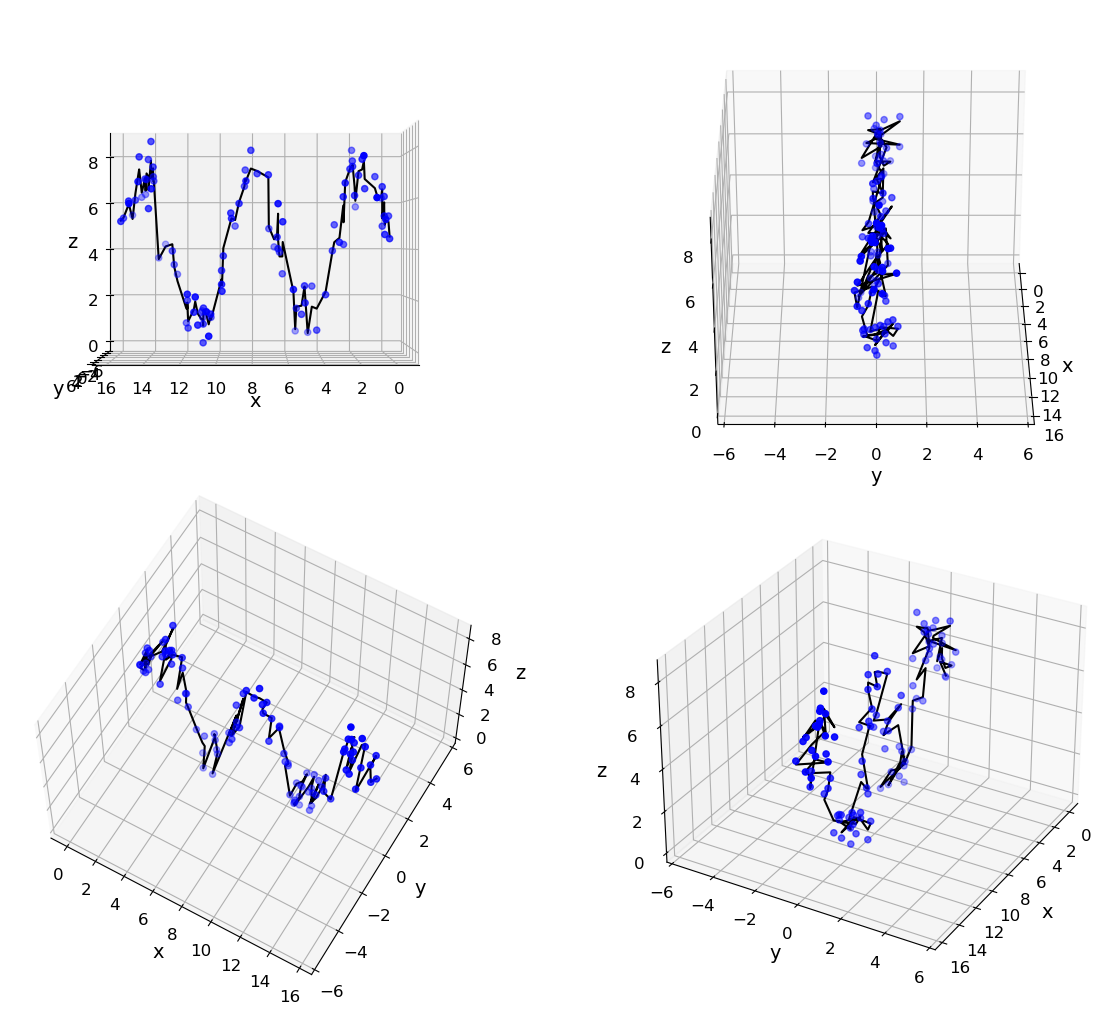

In [19]:
# Predicting using trained model
fit_x = X_train['x']
fit_y = X_train['y']
fit_z = gbrt_optimal.predict(X_train)

# Preparing for sorting
gbrt_optimal_predict = pd.DataFrame({
    'fit_x': fit_x,
    'fit_y': fit_y,
    'fit_z': fit_z
})

# Sorting by fit_x then fit_y
gbrt_optimal_predict.sort_values(by=['fit_x', 'fit_y'], inplace=True)

# Extracting sorted values
gbrt_optimal_x_sorted = gbrt_optimal_predict['fit_x'].values
gbrt_optimal_y_sorted = gbrt_optimal_predict['fit_y'].values
gbrt_optimal_z_sorted = gbrt_optimal_predict['fit_z'].values

plotscatter3Ddata(gbrt_optimal_x_sorted, gbrt_optimal_y_sorted, gbrt_optimal_z_sorted, fit_x, fit_y, z_train)

### Create Optimal RandomForestRegressor Model

In [20]:
rf_best_params = rf3_grid.best_params_

rf_optimal = RandomForestRegressor(**rf_best_params, random_state=42)

rf_optimal.fit(X_train, z_train)

RandomForestRegressor(max_depth=10, n_estimators=250, random_state=42)

### Plot Model Predictions for Training Set

Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

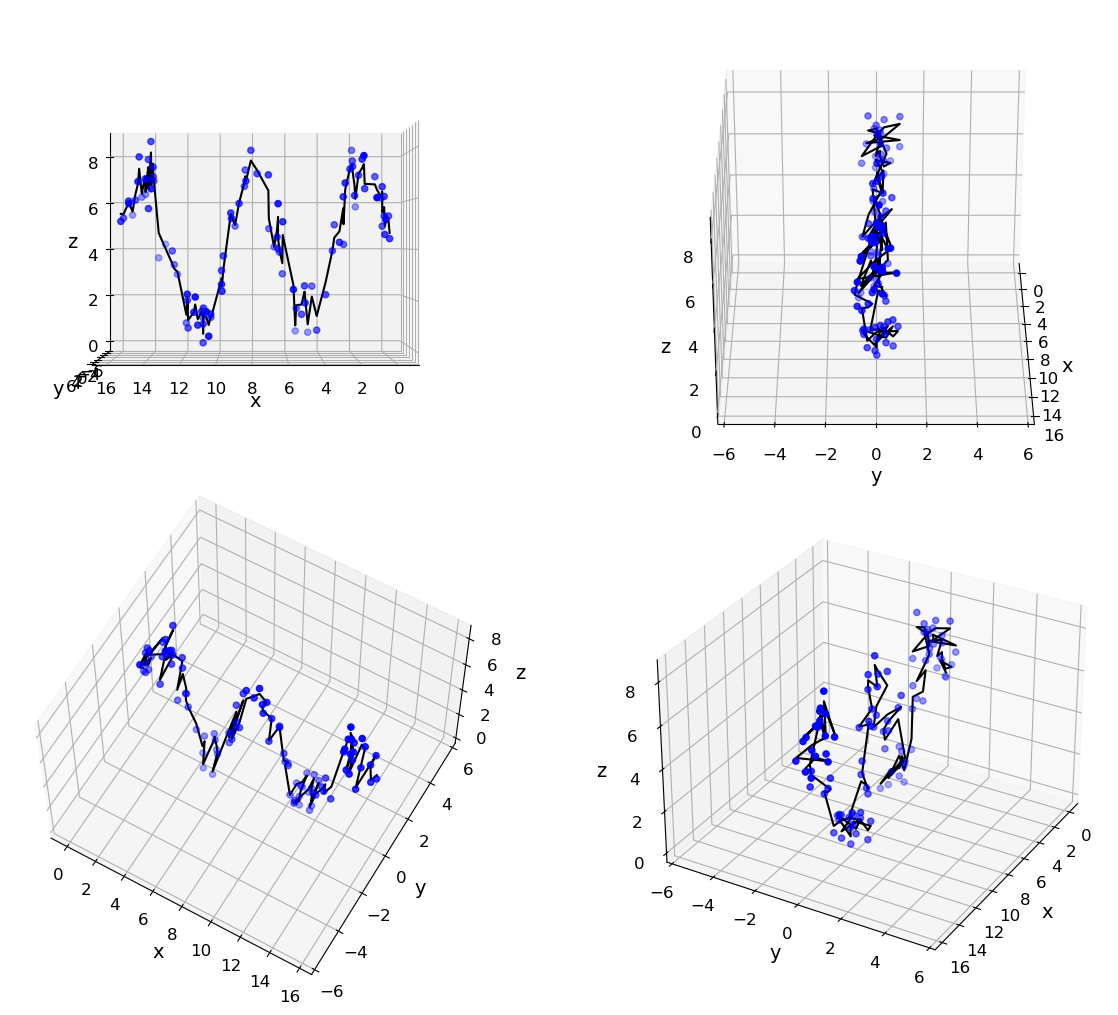

In [21]:
# Predicting using trained model
fit_x = X_train['x']
fit_y = X_train['y']
fit_z = rf_optimal.predict(X_train)

# Preparing for sorting
rf_optimal_predict = pd.DataFrame({
    'fit_x': fit_x,
    'fit_y': fit_y,
    'fit_z': fit_z
})

# Sorting by fit_x then fit_y
rf_optimal_predict.sort_values(by=['fit_x', 'fit_y'], inplace=True)

# Extracting sorted values
rf_optimal_x_sorted = rf_optimal_predict['fit_x'].values
rf_optimal_y_sorted = rf_optimal_predict['fit_y'].values
rf_optimal_z_sorted = rf_optimal_predict['fit_z'].values

plotscatter3Ddata(rf_optimal_x_sorted, rf_optimal_y_sorted, rf_optimal_z_sorted, fit_x, fit_y, z_train)

### Create Optimal DecisionTreeRegressor Model

In [22]:
tree_best_params = tree_reg2.best_params_

tree_optimal = DecisionTreeRegressor(**tree_best_params, random_state=42)

tree_optimal.fit(X_train, z_train)

DecisionTreeRegressor(max_depth=7, min_samples_split=10, random_state=42)

### Plot Model Predictions for Training Set

Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

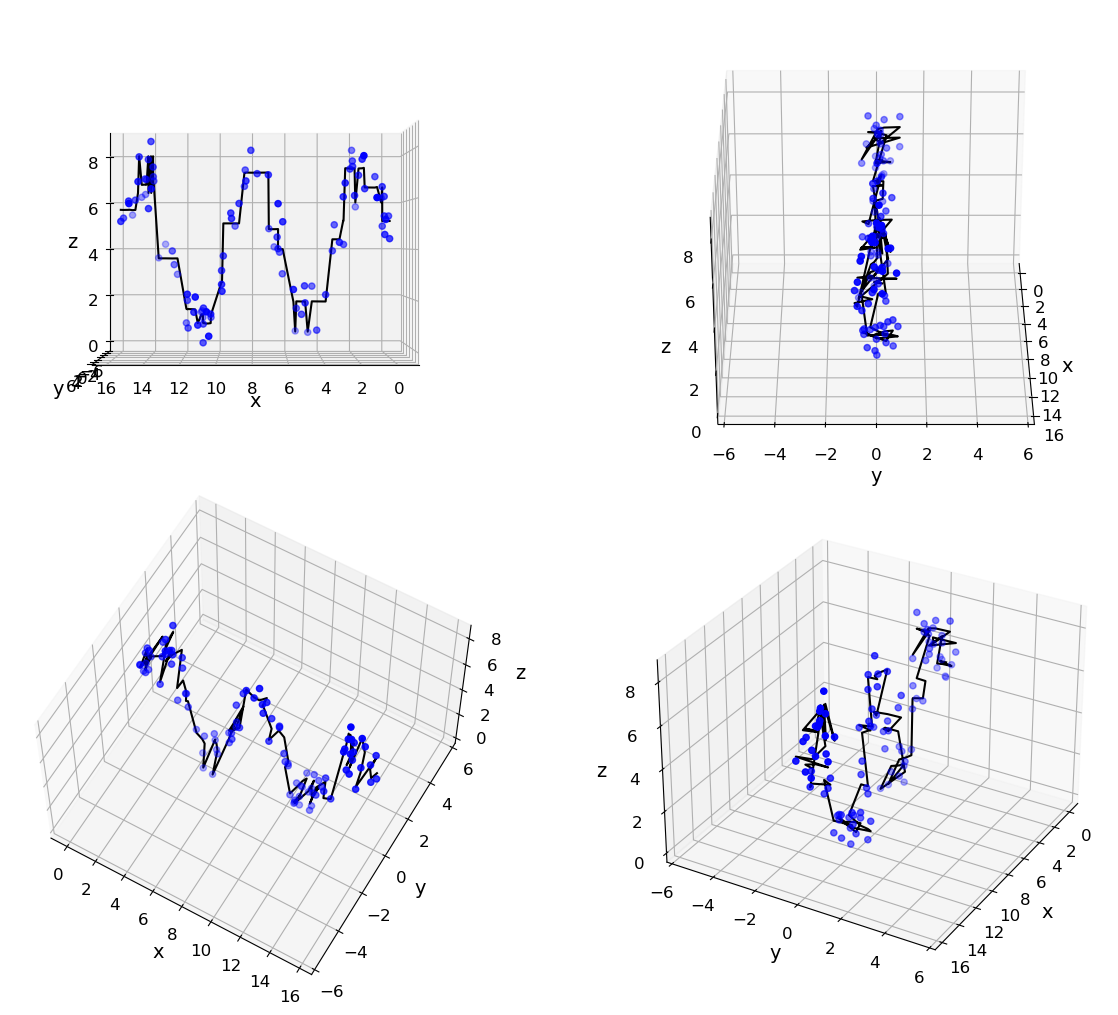

In [23]:
# Predicting using trained model
fit_x = X_train['x']
fit_y = X_train['y']
fit_z = tree_optimal.predict(X_train)

# Preparing for sorting
tree_optimal_predict = pd.DataFrame({
    'fit_x': fit_x,
    'fit_y': fit_y,
    'fit_z': fit_z
})

# Sorting by fit_x then fit_y
tree_optimal_predict.sort_values(by=['fit_x', 'fit_y'], inplace=True)

# Extracting sorted values
tree_optimal_x_sorted = tree_optimal_predict['fit_x'].values
tree_optimal_y_sorted = tree_optimal_predict['fit_y'].values
tree_optimal_z_sorted = tree_optimal_predict['fit_z'].values

plotscatter3Ddata(tree_optimal_x_sorted, tree_optimal_y_sorted, tree_optimal_z_sorted, fit_x, fit_y, z_train)

# Compute Generalization Error

Compute the generalization error for each of the optimal models computed above.  Use MSE as the generalization error metric.  Round your answers to four decimal places.  Print the generalization error for all three models.

In [24]:
gbrt_optimal_mse = round(mean_squared_error(z_test, gbrt_optimal.predict(X_test)),2)
rf_optimal_mse = round(mean_squared_error(z_test, rf_optimal.predict(X_test)),2)
tree_optimal_mse = round(mean_squared_error(z_test, tree_optimal.predict(X_test)),2)

print("GradientBoostingRegressor MSE: ", gbrt_optimal_mse)
print("RandomForestRegressor MSE: ", rf_optimal_mse)
print("DecisionTreeRegressor MSE: ", tree_optimal_mse)

GradientBoostingRegressor MSE:  0.54
RandomForestRegressor MSE:  0.55
DecisionTreeRegressor MSE:  0.73
